# Group 14 - Project FP01
## Time series anomaly detection - LSTM-AD

This project aims at investigating the current state-of-the-arts TAD scenario.

In [2]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [5]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [6]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Loading features from file.
Loading features from file.
Loading features from file.
Loading features from file.
--- 2.3733816146850586 seconds ---


In [7]:
def find_collisions_zones(collisions):
    ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
    ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()
    d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
    collision_zones = pd.DataFrame(d)
    return collision_zones

In [8]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [9]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


In [10]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [11]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [12]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

In [13]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 70)


## LSTM-AD

In [38]:
from algorithms.lstm_ad import LSTMAD

def prepare_data_for_lstm(data, len_in):
    """
    Prepare data for LSTM-AD by concatenating every len_in rows.
    """
    n_features = data.shape[1]
    n_samples = data.shape[0] // len_in
    prepared_data = data.iloc[:n_samples * len_in].values.reshape(n_samples, -1)
    return pd.DataFrame(prepared_data, index=data.index[len_in-1:len_in*n_samples:len_in])

# CURRENTLY FUCKS UP FOR VALUES OF LEN_IN AND LEN_OUT DIFFERENT FROM 1
len_in = 1
X_train_lstm = prepare_data_for_lstm(X_train, len_in)
print(X_train_lstm.shape)

classifier = LSTMAD(
    len_in=len_in,         # Input sequence length
    len_out=1,             # Output sequence length (prediction horizon)
    num_epochs=100,         # Number of training epochs
    lr=1e-2,               # Learning rate
    batch_size=1,          # Batch size (usually 1 for time series)
    seed=42,               # Random seed for reproducibility
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True           # Set to True to get detailed predictions
)

# Train the LSTM on normal data
classifier.fit(X_train_lstm)
print("LSTM-AD training completed.")


(973, 96)


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

LSTM-AD training completed.


In [39]:
y_preds = classifier.predict(X_test)

In [40]:
y_preds

array([            nan,  3.28218639e+05,  1.36684232e+05,  7.93333585e+05,
        3.94339462e+05,  3.15830632e+05,  2.51063255e+05,  2.38011487e+05,
        3.18770312e+05,  3.19915077e+05,  3.33625019e+05,  6.28935520e+04,
        1.12401498e+04,  3.21919021e+03,  3.39532621e+03,  7.73752862e+01,
        6.49882875e+03,  2.41085967e+02,  8.68694135e+03,  7.48173147e+01,
        4.92708074e+04,  1.18458574e+02,  3.04595970e+05,  3.03541090e+04,
        1.45949442e+02,  1.17789330e+05,  2.22972833e+03,  3.12432123e+03,
        6.23199696e+01,  1.72746578e+03,  1.09186813e+05,  2.37156586e+04,
        3.64713412e+04,  2.15538078e+04,  2.32657010e+04,  2.24324331e+04,
        2.13288439e+04,  2.23834645e+04,  2.25237090e+04,  2.14235363e+04,
        2.18710005e+04,  3.31631234e+04,  3.21308846e+04,  2.41384167e+04,
        2.19797801e+04,  2.19240274e+04,  5.61005919e+04,  3.81082287e+04,
        3.33941284e+05,  7.30246688e+04,  2.13651151e+04,  7.10288598e+04,
        6.08578148e+04,  

### Anomaly Detection

In [41]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [42]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 5 with threshold 1007011.0296708618, std
Number of anomalies detected: 78 with threshold 65572.53522621989, mad
Number of anomalies detected: 16 with threshold 326142.7484032738, percentile
Number of anomalies detected: 24 with threshold 165009.90069251583, IQR

Number of anomalies detected: 5 with threshold 420861.07539476146, std
Number of anomalies detected: 41 with threshold 33705.27864621047, mad
Number of anomalies detected: 9 with threshold 281292.4557711397, percentile
Number of anomalies detected: 25 with threshold 84751.2849675042, IQR

Number of anomalies detected: 2 with threshold 1408555.9457855653, std
Number of anomalies detected: 23 with threshold 105382.84953450269, mad
Number of anomalies detected: 8 with threshold 333450.9272352849, percentile
Number of anomalies detected: 14 with threshold 164577.98787845523, IQR



In [43]:
y_collisions_predict = anomaly_scores > thresholds[1]
y_collisions_predict1 = anomaly_scores1 > thresholds_1[1]
y_collisions_predict5 = anomaly_scores5 > thresholds_5[1]

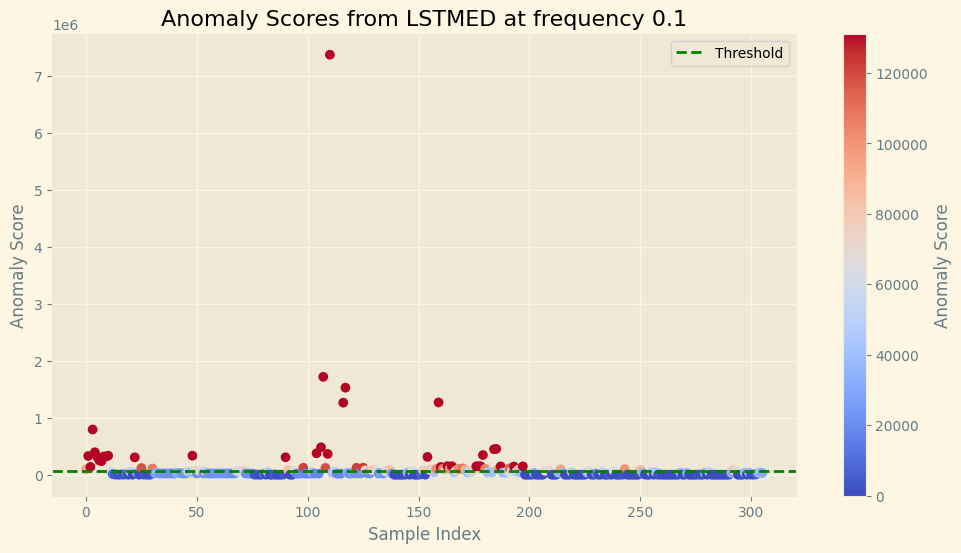

Number of anomalies detected: 78


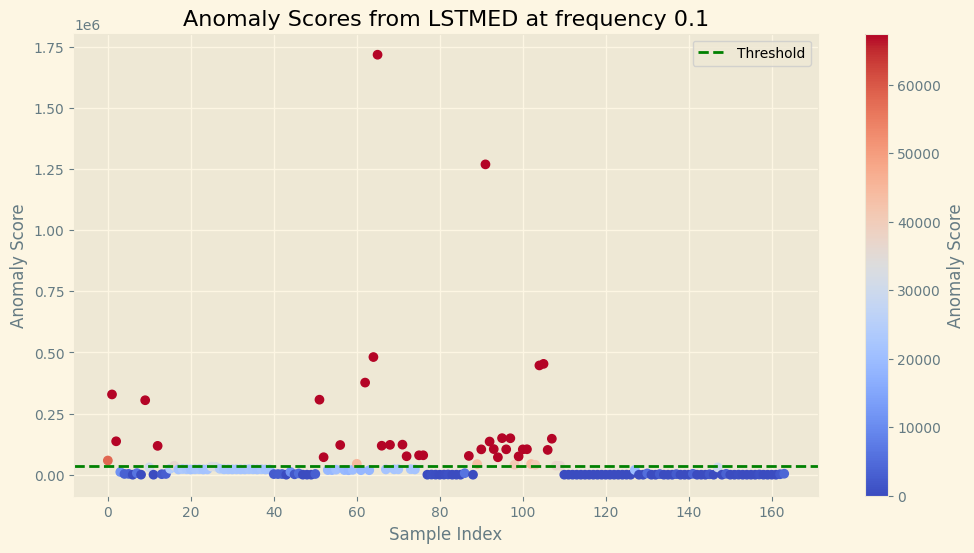

Number of anomalies detected: 41


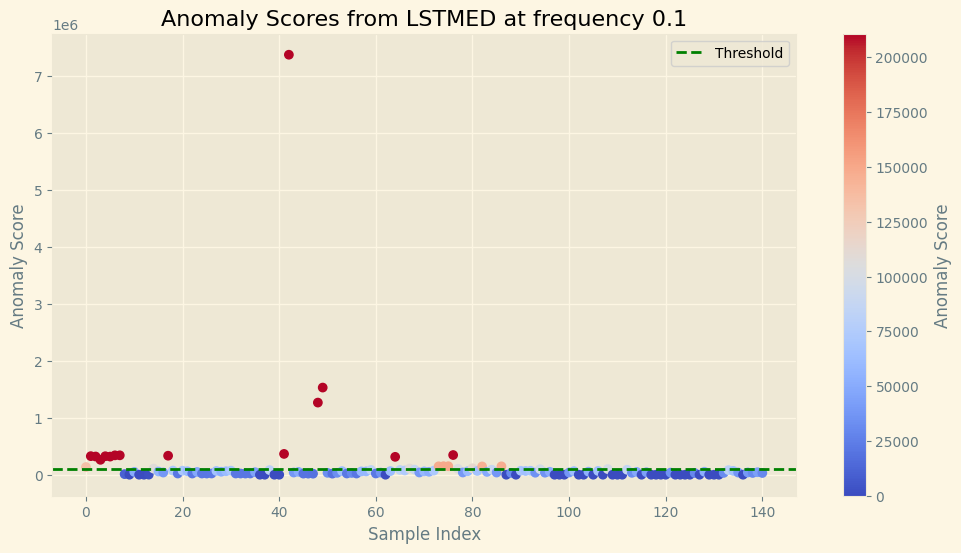

Number of anomalies detected: 23


In [44]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [45]:
X_test_start_end['anomaly_scores'] = anomaly_scores
X_test_start_end['is_collision'] = y_collisions_predict
X_test_start_end1['anomaly_scores'] = anomaly_scores1
X_test_start_end1['is_collision'] = y_collisions_predict1
X_test_start_end5['anomaly_scores'] = anomaly_scores5
X_test_start_end5['is_collision'] = y_collisions_predict5

In [46]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

Threshold: 65572.5352
ROC AUC Score: 0.7627
F1 Score: 0.4481
Accuracy: 0.6699
Precision: 0.5256
Recall: 0.3905
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       201
           1       0.53      0.39      0.45       105

    accuracy                           0.67       306
   macro avg       0.62      0.60      0.61       306
weighted avg       0.65      0.67      0.66       306

############################################
Threshold: 33705.2786
ROC AUC Score: 0.6704
F1 Score: 0.3158
Accuracy: 0.6829
Precision: 0.2927
Recall: 0.3429
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       129
           1       0.29      0.34      0.32        35

    accuracy                           0.68       164
   macro avg       0.55      0.56      0.55       164
weighted avg       0.70      0.68      0.69       164

############################################
Threshold: 105382.8495
ROC AUC Sco

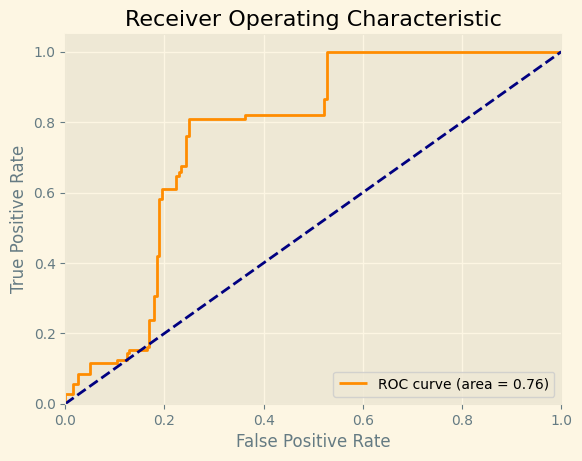

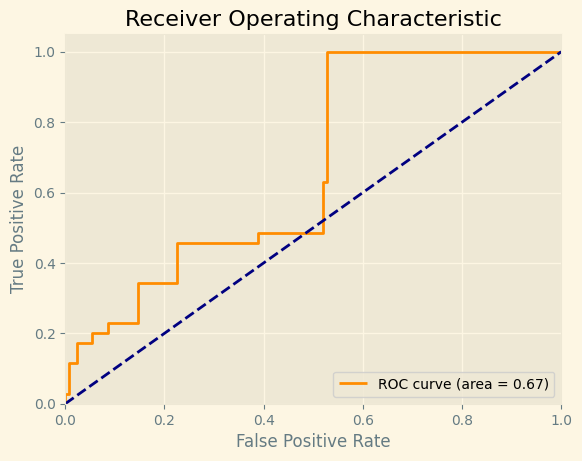

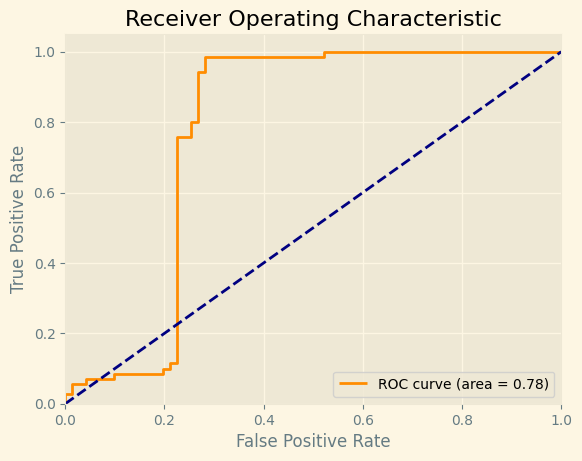

In [47]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [48]:
def convert_to_df(collisions_zones):
    collisions_zones_df = pd.DataFrame(collisions_zones)
    # change the type of the columns to datetime
    collisions_zones_df['start'] = pd.to_datetime(collisions_zones_df['start'])
    collisions_zones_df['end'] = pd.to_datetime(collisions_zones_df['end'])
    
    return collisions_zones_df

In [49]:
collisions_zones_df = convert_to_df(collisions_zones)
collisions_zones_df_1 = convert_to_df(collisions_zones_1)
collisions_zones_df_5 = convert_to_df(collisions_zones_5)

In [50]:
plot_anomalies_true_and_predicted(df_collision, df_action_collision, collisions_zones_df, X_test_start_end, title="Normal data with predicted collisions", saveplot=False)

In [51]:
plot_anomalies_true_and_predicted(df_collision_1, df_action_collision_1, collisions_zones_df_1, X_test_start_end1, title="Collision 1 data with predicted collisions", saveplot=False)

In [52]:
plot_anomalies_true_and_predicted(df_collision_5, df_action_collision_5, collisions_zones_df_5, X_test_start_end5, title="Collision 5 data with predicted collisions", saveplot=False)